## 1.Cargando la información y librerias

In [599]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import f_oneway


In [600]:
# Configuration para visualización de filas y de columnas
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

# Cargando el archivo .csv. El archivo corresponde a la información de la ciudad de Buenos Aires, Argentina
listings_df = pd.read_csv("./data/listings.csv.gz")

## 2.Información de la base de datos

In [601]:
# Dimensiones de la base de datos
listings_df.shape

(26204, 75)

In [602]:
#  Registros unicos
listings_df["id"].nunique()

26204

In [603]:
# Tipos de las columnas/atributos de la base de datos
listings_df.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
source                                           object
name                                             object
description                                      object
neighborhood_overview                            object
picture_url                                      object
host_id                                           int64
host_url                                         object
host_name                                        object
host_since                                       object
host_location                                    object
host_about                                       object
host_response_time                               object
host_response_rate                               object
host_acceptance_rate                            

In [604]:
# Muestra un ejemplo, de 5 filas
listings_df.sample(5) 

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
6404,32510736,https://www.airbnb.com/rooms/32510736,20230628025456,2023-06-29,city scrape,Rental unit in Palermo · ★4.93 · 1 bedroom · 1...,Muy bien ubicado y luminosos el departamento t...,Tiene una ubicación excelente para disfrutar d...,https://a0.muscache.com/pictures/2703aa17-88ca...,6209382,https://www.airbnb.com/users/show/6209382,Virginia,2013-05-03,"Buenos Aires, Argentina","Soy actriz, directora, docente de teatro y ges...",within a few hours,100%,83%,t,https://a0.muscache.com/im/users/6209382/profi...,https://a0.muscache.com/im/users/6209382/profi...,Palermo,1,2,"['email', 'phone']",t,t,"Palermo, Buenos Aires, Argentina",Palermo,NaN,-34.58490,-58.42012,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Free street parking"", ""Elevator"", ""Essential...","$5,110.00",6,1125,6,6,1125,1125,6.0,1125.0,NaN,t,0,0,4,188,2023-06-29,14,1,0,2019-03-29,2022-11-28,4.93,4.71,4.79,5.00,4.93,5.00,4.86,NaN,f,1,1,0,0,0.27
14925,681958740736160966,https://www.airbnb.com/rooms/681958740736160966,20230628025456,2023-06-28,city scrape,Rental unit in Belgrano · ★4.80 · 1 bedroom · ...,"Con calor de hogar, cerca de donde necesitas e...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,1096393,https://www.airbnb.com/users/show/1096393,Gisela,2011-09-01,"Buenos Aires, Argentina",Somos una pareja joven y emprendedora. Nos gus...,within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/4c2fe...,https://a0.muscache.com/im/pictures/user/4c2fe...,Belgrano,8,8,"['email', 'phone']",t,t,NaN,Belgrano,NaN,-34.55281,-58.45082,Entire rental unit,Entire home/apt,3,NaN,2 baths,1.0,2.0,"[""AC - split type ductless system"", ""Elevator""...","$25,221.00",1,365,1,2,28,365,1.2,349.6,NaN,t,23,52,82,236,2023-06-28,5,5,0,2022-11-05,2022-12-22,4.80,4.60,4.60,4.60,4.80,4.60,4.40,NaN,t,8,8,0,0,0.64
3224,18448257,https://www.airbnb.com/rooms/18448257,20230628025456,2023-06-29,city scrape,Rental unit in Recoleta · ★5.0 · 1 bedroom · 2...,¡A NUEVO! Lindísimo y acogedor departamento en...,A metros de Av. Santa Fe y pocas cuadras de la...,https://a0.muscache.com/pictures/0c5cf0a7-ffbb...,127892146,https://www.airbnb.com/users/show/127892146,Silvina,2017-04-27,"Buenos Aires, Argentina",NaN,within an hour,100%,94%,t,https://a0.muscache.com/im/pictures/user/a7a6f...,https://a0.muscache.com/im/pictures/user/a7a6f...,Recoleta,1,2,"['email', 'phone']",t,t,"Recoleta, Buenos Aires, Argentina",Recoleta,NaN,-34.59659,-58.39062,Entire rental unit,Entire home/apt,3,NaN,1 bath,1.0,2.0,"[""Free street parking"", ""Shower gel"", ""Hot wat...","$8,943.00",5,35,5,5,35,35,5.0,35.0,NaN,t,7,37,67,341,2023-06-29,30,11,1,2017-09-12,2023-06-21,5.00,4.90,5.00,4.97,5.00

Como se evidencia, en las anteriores lineas de codigo, la base de datos cuenta con 26204 registros en la base de datos, lo cual implica que contamos con la información de 26204 predios en la ciudad de Buenos Aires Argentina, inscritos en la plataforma de AirBNB. Tenemos 75 atributos para esta base de datos, los cuales cuentan con información clave como es:

* Host de los predios
* Información de los predios (Cantidad de baños, capacidad, tipo de predio, geolocalización, barrio, amenidades)
* Valor por noche de cada predio
* Cantidad de noches promedio por predio en diferentes intervalos de tiempo
* Review de los predios

Ya que el objetivo del siguiente analisis es obtener información relevante acerca de la rentabilidad esperada que puede tener un predio en la ciudad de Buenos Aires, nos centraremos en algunos atributos especificos, cuya relevancai sera exzplicada mas adelante. Los atributos consdierados mas relevantes seran:

* "price":                  Corresponde al precio por noche del predio, se encuentra en moneda local                                    Object
* "room_type"               Corresponde al tipo de predio. Se divide entre "Entire place", "Private Room" y "Shared Room".              Object
* "bedrooms":               Cantidad de habitaciones                                                                                    float
* "availability_xx":        Este corresponden a la disponibilidad del predio en los ultimos xx dias.                                    Integer
* "number_of_reviews_ltm":  Corresponde a la cantidad de reviews que ha tenido el predio en el ultimo año                               Integer
* "neighbourhood_cleansed": Barrio del predio                                                                                           Object
* Variables de review:      Set de variables que determinan comportamientos claves de la forma en la que se comportan los reviews (Su aproximación se hara en la parte multivariada)

## 3.Analisis Univariado

* 3.1 Price:


In [605]:
#Ejemplo de price
listings_df["price"].sample(5) 

22296    $7,785.00
22284    $7,643.00
2164     $9,171.00
4679     $5,029.00
8124     $7,900.00
Name: price, dtype: object

In [606]:
# Considerando que este cuenta con valores no numericos, se transforma con la siguiente linea a un valor tipo float. Se añade la columna "price_float"
listings_df["price_float"] = listings_df["price"].str.replace("[$,]", "", regex=True).astype(float)

In [607]:
#Distribución por percentiles
listings_df["price_float"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.9, 0.95])

count    2.620400e+04
mean     1.752933e+04
std      1.754018e+05
min      1.750000e+02
5%       4.331000e+03
25%      7.406500e+03
50%      1.019000e+04
75%      1.528600e+04
90%      2.456600e+04
95%      3.397675e+04
max      2.529509e+07
Name: price_float, dtype: float64

In [608]:
#Como se evidencia anteriormente, se cuenta con valores muy altos y probablemente atipicos en el precio de los predios. Se procede a organizarlos de acuerdo a esto, junto con otros atributos, para determinar si corresponde a predios 
#particularmente grandes
listings_df[["accommodates", "bathrooms_text", "bedrooms", "price_float"]].sort_values(by=["price_float"])

,accommodates,bathrooms_text,bedrooms,price_float
4373,1,1 shared bath,NaN,175.0
963,2,1 bath,1.0,260.0
2971,1,1.5 baths,NaN,400.0
5009,1,1 shared bath,NaN,450.0
3994,1,1 private bath,NaN,500.0
...,...,...,...,...
25302,3,1 bath,1.0,3799230.0
9020,2,1 bath,1.0,4036994.0
13132,1,1 shared bath,NaN,4500000.0
14401,3,1 bath,1.0,4568081.0


In [609]:
#Como se evidencia anteriormente, no correspoonde a predios particularmente grandes. Se procede a realizar anexar una variable de tipo boolean, donde se tendran valores True a los predios que esten dentro del rango
#<=(q3 + 3*(q3-q1))

q1 = listings_df["price_float"].quantile(0.25)
q3 = listings_df["price_float"].quantile(0.75)
listings_df["On_Price_Q1-Q3_Range"] = listings_df["price_float"] <= (q3 + 3 * (q3-q1))
listings_df["On_Price_Q1-Q3_Range"].value_counts(dropna=False, normalize=True)

On_Price_Q1-Q3_Range
True     0.963822
False    0.036178
Name: proportion, dtype: float64

count    25256.000000
mean     11772.415505
std       6782.258376
min        175.000000
25%       7309.750000
50%       9936.000000
75%      14215.500000
max      38837.000000
Name: price_float, dtype: float64

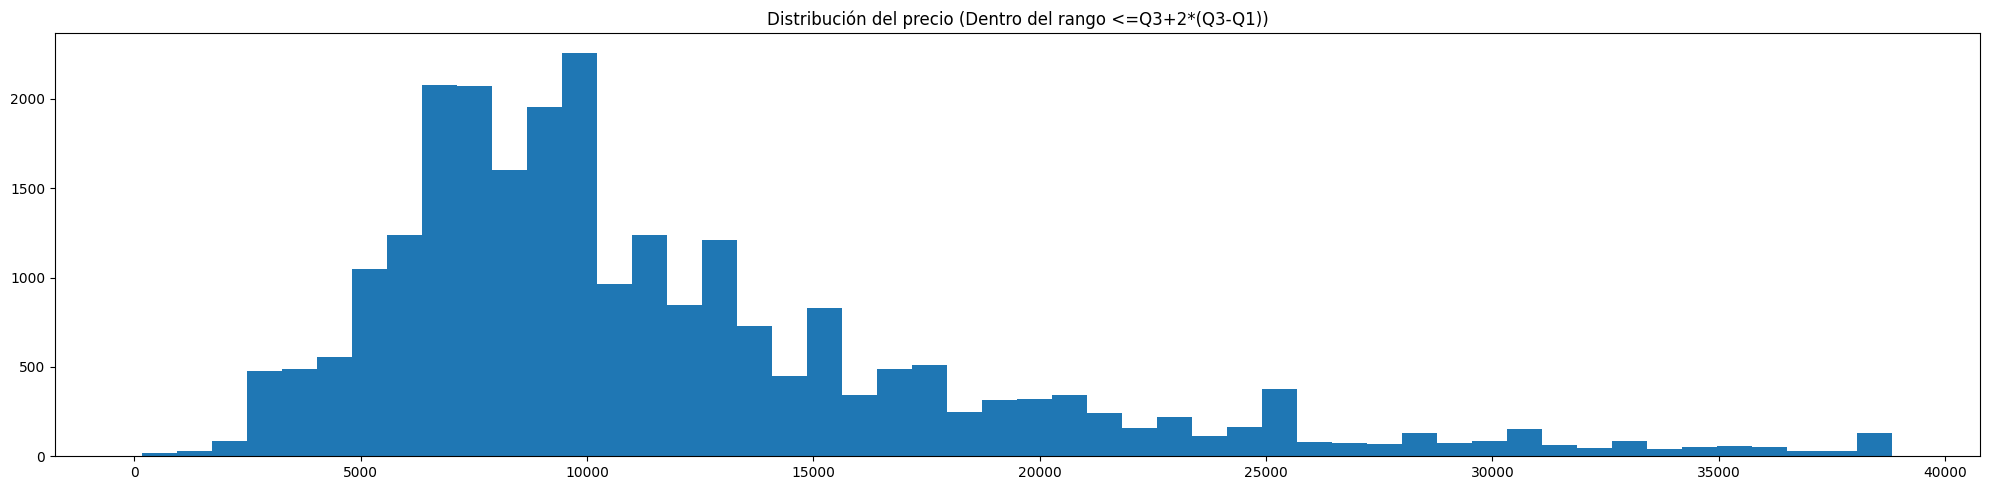

In [610]:
#A patir de esto, se grafica un histograma para ver la distribución de precios
plt.figure(figsize=(20, 5))
plt.hist(listings_df.loc[listings_df["On_Price_Q1-Q3_Range"]]["price_float"], bins=50)
plt.title("Distribución del precio (Dentro del rango <=Q3+2*(Q3-Q1))")
plt.plot()
listings_df.loc[listings_df["On_Price_Q1-Q3_Range"]]["price_float"].describe(percentiles=[0.25, 0.5, 0.75])


Como se evidencia en el analisis univariado anterior, el precio requeria de diversas correcciones entre ellas, la correción del tipo de dato para facilitar y permitir su analisis. Por otro lado fue necesario marcar los registros con valores por fuera del rango de Q1 + 3*(Q3-Q1), dado que en el percentil 95% teniamos valores que rondaban el orden de maginutd de 1*10e4, sin embargo el valor maximo estaba 3 ordenes de magnitud por encima, estos valores probablemente atipicos iban a increementar considerablemente el promedio y la varianza de la medida, afectando el analisis. 

Posteriormente, se grafico el histograma de la distribución y se calculo la media aritmetica y la desviación estandar, mostrando que la media de los valores esta en 11722.41 ARS con una desviación estandar de 6782.25 ARS. Considerando el rango [media - 1 desviacion estandar, Media + 1 desvaicion estandar], la mayor parte de datos esta entre 4990.15 y 18554.67 ARS. En terminos de percentiles, el 75% de los datos muestra valores inferiores a 14215.5 ARS

De aqui en adelante, se considerara para el analisis, solo los valores que esten en el rango de precio Q1 + 3*(Q3-Q1). Esto considerando que el precio es el eje fundamental del presente analisis

* 3.2 Room_type:

Al ser una variable de tipo OBJECT/STRING, vamos a determinar los valores unicos, y ver su distribución

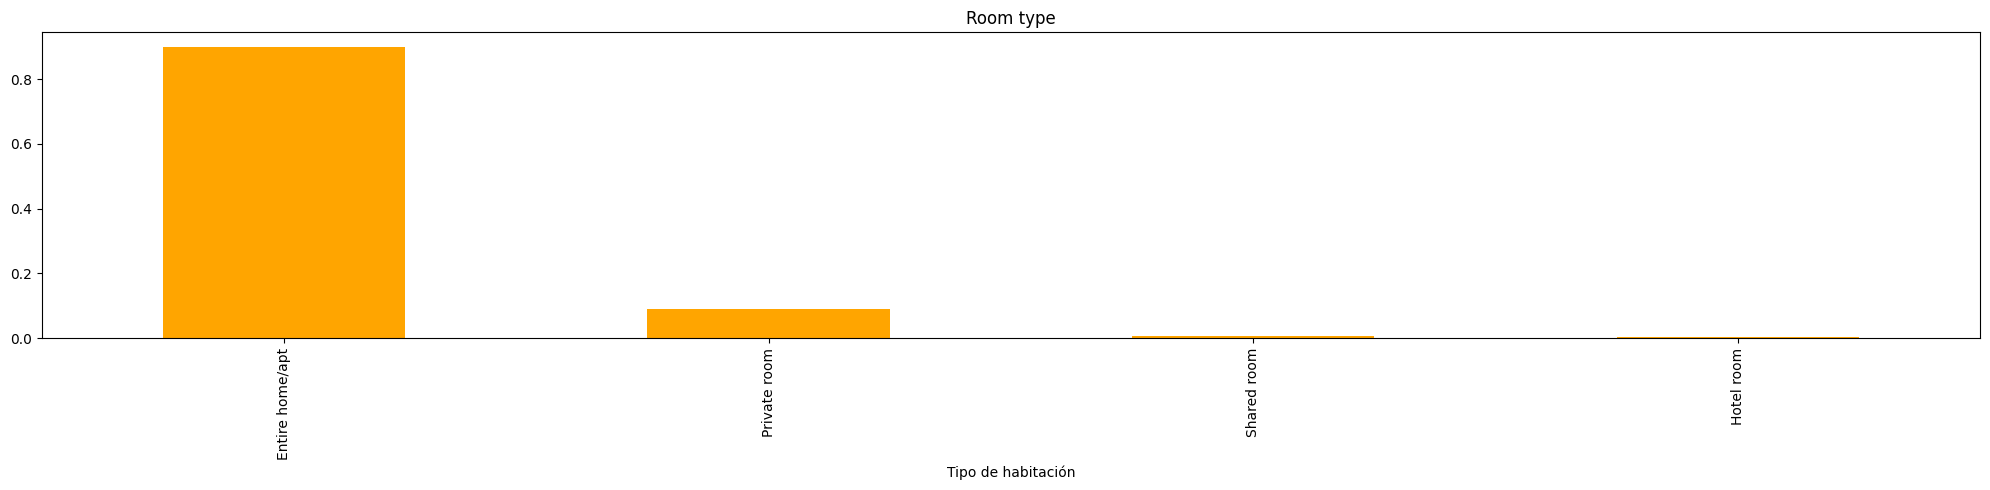

room_type
Entire home/apt    23556
Private room        2343
Shared room          206
Hotel room            99
Name: count, dtype: int64

In [611]:
#grafica de tipo barra de los valores normalizados de cada tipo de habitación
plt.figure(figsize=(20, 5))
listings_df.loc[listings_df["On_Price_Q1-Q3_Range"]]["room_type"].value_counts(dropna=False, normalize=True).plot(kind="bar", color="orange")
plt.title("Room type")
plt.xlabel("Tipo de habitación")
plt.show()
listings_df["room_type"].value_counts(dropna=False, normalize=False) 


Como se evidencia anteriormente, casi el 90% de los predios corresponden a casas o apartamentos enteros, cerca del 9% corresponden a cuartos privados. Por ende un poco mas del 1% corresponde a habitaciones compartidas y cuartos de hotel. Considernado la información obtenida, centraremos nuestro analisis en casas o apartamentos enteros o en cuartos privados

* 3.3 Bedrooms

count    19807.000000
mean         1.303024
std          0.684476
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
90%          2.000000
95%          2.000000
99%          3.000000
max         35.000000
Name: bedrooms, dtype: float64
count    19780.000000
mean         2.951517
std          1.186414
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
90%          4.000000
95%          5.000000
99%          6.000000
max         16.000000
Name: accommodates, dtype: float64


[]

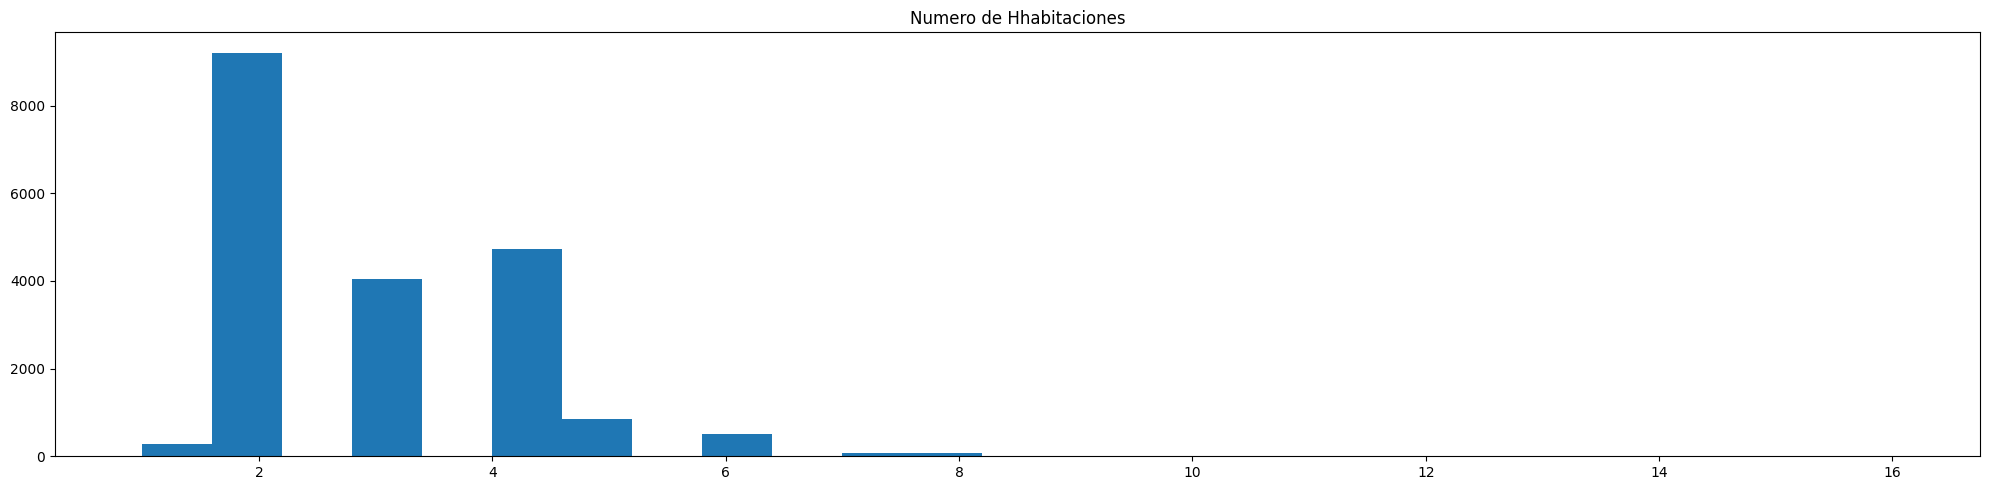

In [612]:
#Distribución por percentiles y valores estadisticos de la cantidad de habitaciones
print(listings_df.loc[listings_df["On_Price_Q1-Q3_Range"]]["bedrooms"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

#Se cambia el valor, a incluir los valores que se encuentran dentro del rango <= q3+3*(q3-q))
q1 = listings_df["bedrooms"].quantile(0.25)
q3 = listings_df["bedrooms"].quantile(0.75)
iqr = q3-q1

#Distribución por percentiles y valores estadisticos
print(listings_df.loc[(listings_df["bedrooms"]<= q3+3*iqr)&(listings_df["On_Price_Q1-Q3_Range"])]["accommodates"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

#Histograma de distribución
plt.figure(figsize=(20, 5))
plt.hist(listings_df.loc[(listings_df["bedrooms"]<= q3+3*iqr)&(listings_df["On_Price_Q1-Q3_Range"])]["accommodates"], bins=25)
plt.title("Numero de Hhabitaciones")
plt.plot()


In [613]:
#Calculo del estimativo de camas por habitación
a = (listings_df.loc[listings_df["On_Price_Q1-Q3_Range"]]["beds"]/listings_df.loc[listings_df["On_Price_Q1-Q3_Range"]]["bedrooms"]).value_counts(normalize=True)
print(a)
Estimado_habitaciones = (a[1]*1+a[2]*2+a[3]*1.5)/(a[1]+a[2]+a[3])
print(Estimado_habitaciones)


1.000000     0.551449
2.000000     0.228317
1.500000     0.088612
3.000000     0.065531
4.000000     0.016624
1.333333     0.014540
0.500000     0.008287
1.666667     0.007728
2.500000     0.006965
5.000000     0.001525
6.000000     0.001423
0.333333     0.001322
1.250000     0.001271
0.250000     0.000966
0.666667     0.000763
14.000000    0.000763
2.333333     0.000559
10.000000    0.000458
2.666667     0.000407
3.500000     0.000356
0.142857     0.000356
1.750000     0.000203
7.000000     0.000153
0.125000     0.000153
0.090909     0.000102
0.071429     0.000102
0.166667     0.000102
0.800000     0.000102
1.800000     0.000102
0.100000     0.000051
3.333333     0.000051
9.000000     0.000051
4.500000     0.000051
3.666667     0.000051
3.800000     0.000051
0.750000     0.000051
1.428571     0.000051
1.833333     0.000051
0.833333     0.000051
0.428571     0.000051
4.666667     0.000051
5.500000     0.000051
0.200000     0.000051
2.250000     0.000051
Name: proportion, dtype: float64

In [614]:
#Generación de la columna bedrooms_modified donde se contempla el caluclo para el caso que se tienen NaN
listings_df["bedroom_modified"]=listings_df["bedrooms"]
listings_df.loc[listings_df["bedrooms"].isna(),"bedrooms_modified"] = round(listings_df["beds"]/Estimado_habitaciones)
print(listings_df.loc[(listings_df["On_Price_Q1-Q3_Range"])]["bedrooms_modified"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
#print(listings_df.loc[(listings_df["On_Price_Q1-Q3_Range"])]["bedrooms"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

#Se cambia el valor, a incluir los valores que se encuentran dentro del rango <= q3+3*(q3-q))
q1 = listings_df["bedrooms_modified"].quantile(0.25)
q3 = listings_df["bedrooms_modified"].quantile(0.75)
iqr = q3-q1

#Distribución por percentiles y valores estadisticos
print(listings_df.loc[(listings_df["bedrooms_modified"]<= q3+3*iqr)&(listings_df["On_Price_Q1-Q3_Range"])]["bedrooms_modified"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))


count    5347.000000
mean        1.427903
std         0.981017
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
90%         2.000000
95%         2.000000
99%         5.000000
max        13.000000
Name: bedrooms_modified, dtype: float64
count    5303.000000
mean        1.361493
std         0.621812
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
90%         2.000000
95%         2.000000
99%         4.000000
max         5.000000
Name: bedrooms_modified, dtype: float64


In [615]:
#A partir de lo previamente visualizado, se procecede a modificar la columna On_Price_Q1-Q3_Range para incluir los registros que se encuentren en este rango para los atributos price y bedrooms_modified
listings_df.loc[listings_df["On_Price_Q1-Q3_Range"],"On_Price_Q1-Q3_Range"] = listings_df["bedrooms_modified"]<= q3+3*iqr
listings_df["On_Price_Q1-Q3_Range"].value_counts()

On_Price_Q1-Q3_Range
False    20901
True      5303
Name: count, dtype: int64

Como se evidencio anteriormente, se realizo el analisis univariado del atributo bedrooms, donde se encontro que mas del 20% de los valores son NaN. Por ende, se realiza una transformación en una columna nuea, en la cual se determina el valor de las habitaciones como la cantidad de camas, sobre el estimado de camas que hay por habitación, claramente solo para los valores de Nan. Este consolidado se obtuvo como el promedio ponderado de la cantidad de camas por habitación, del 90% de los valores.

Depues de esta transformación, se evidencia que los valores de Media y desviación estandar no cambiaron significativamente

Se muestra que el 99% de los predios tienen al menos 4 habitaciones, y al menos el 75% tiene por lo menos dos habitaciones

* 3.4 availability_365  y  number_of_reviews_ltm

In [616]:
#Información estadistica 
print(listings_df.loc[listings_df["On_Price_Q1-Q3_Range"]]["availability_365"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
print(listings_df.loc[listings_df["On_Price_Q1-Q3_Range"]]["number_of_reviews_ltm"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

count    5303.000000
mean      215.574015
std       130.175630
min         0.000000
25%        89.000000
50%       226.000000
75%       348.000000
90%       364.000000
95%       365.000000
99%       365.000000
max       365.000000
Name: availability_365, dtype: float64
count    5303.000000
mean       10.184801
std        16.074579
min         0.000000
25%         0.000000
50%         3.000000
75%        14.000000
90%        30.000000
95%        41.000000
99%        64.960000
max       377.000000
Name: number_of_reviews_ltm, dtype: float64


[]

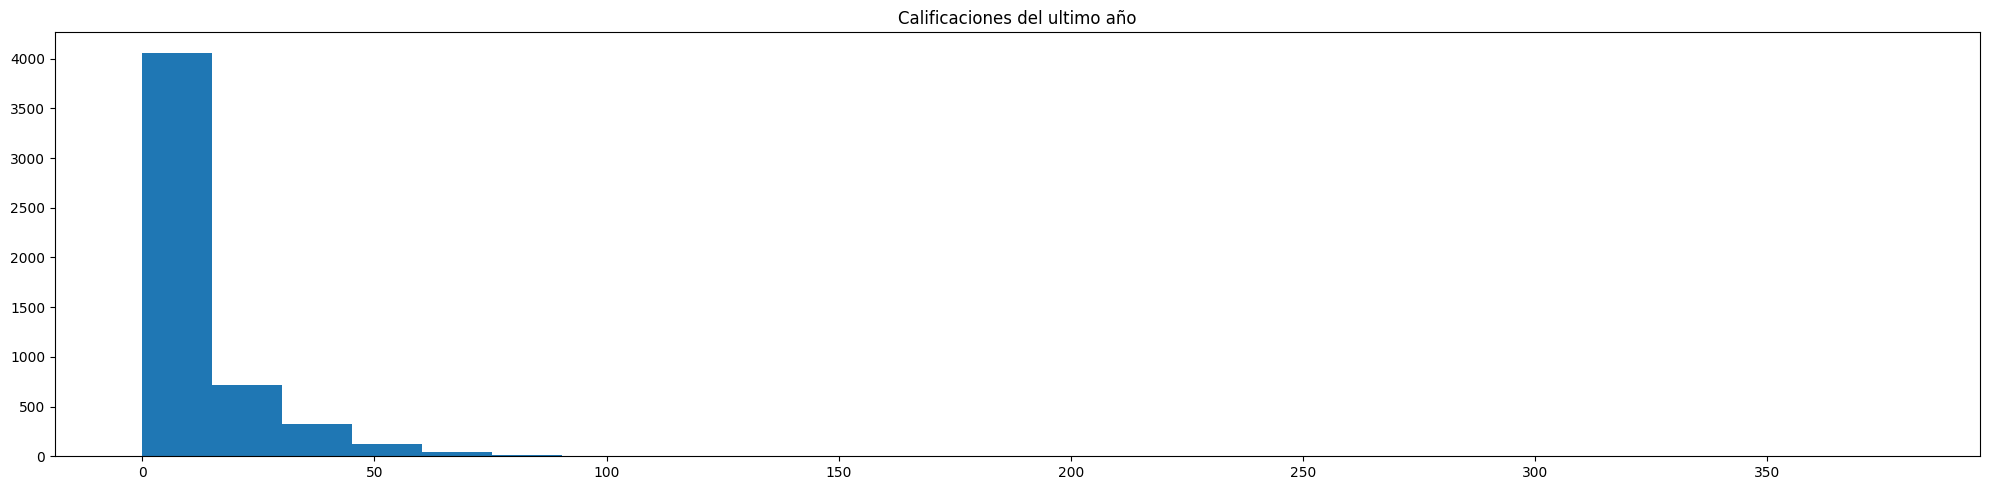

In [617]:
#Histograma numero de reviews
plt.figure(figsize=(20, 5))
plt.hist(listings_df.loc[(listings_df["On_Price_Q1-Q3_Range"])]["number_of_reviews_ltm"], bins=25)
plt.title("Calificaciones del ultimo año")
plt.plot()

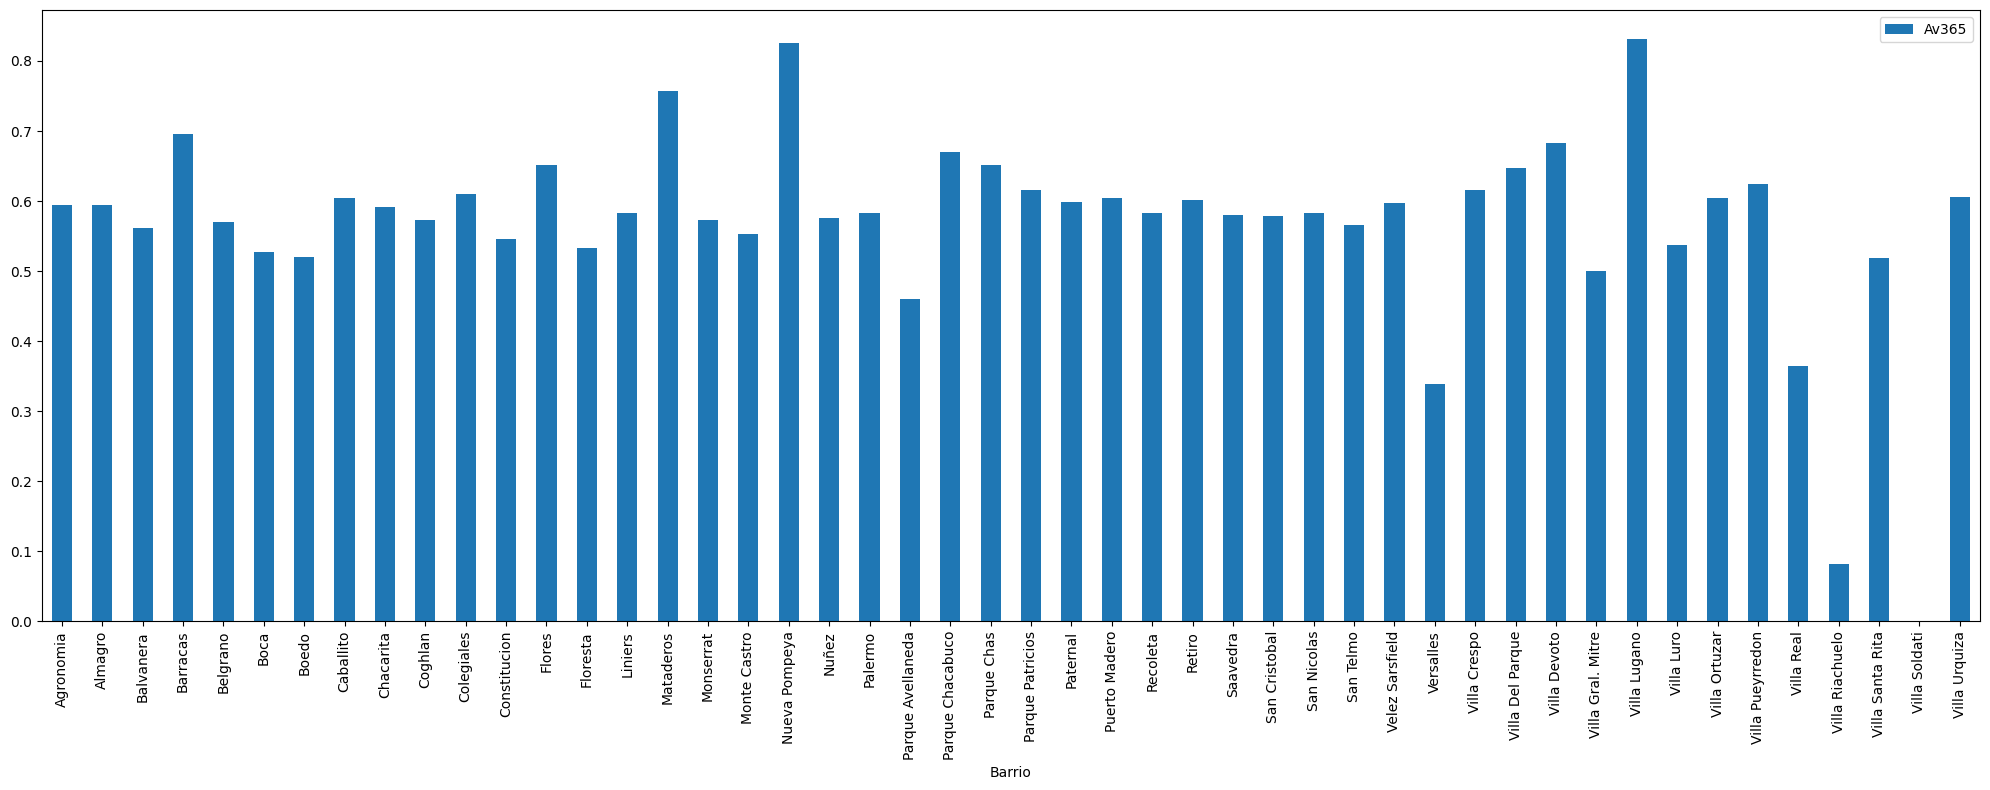

In [618]:
#Histograma disponibilidad del ultimo año
Data = {"Av365": listings_df.groupby(["neighbourhood_cleansed"])["availability_365"].mean()/365}

df_Availability = pd.DataFrame(Data,columns=['Av365'])

fig, ax1 = plt.subplots(1, 1, figsize=(20, 8))
df_Availability.plot.bar(ax = ax1)
plt.xlabel("Barrio")
plt.show()

Como se puede evidenciar anteriormente, las variables de availability_365 y number_of_reviews_ltm, presentan una distribución orientada a mayor disponibilidad a lo largo del año, es decir, la mayoria de predios matienen alta disponibilidad a lo largo del año, lo cual va acompañado de una pequeña cantidad de review en la mayoria de predios. Estas dos variables entraran a definir un papel crucial en al demanda y oferta de los predios. 

* 3.5 neighbourhood_cleansed

In [619]:
#Display de la totalidad de barrios contenidos en la base de datos
print(listings_df["neighbourhood_cleansed"].unique())
print(listings_df["neighbourhood_cleansed"].nunique())

['Palermo' 'Recoleta' 'Nuñez' 'Monserrat' 'Balvanera' 'Retiro'
 'Constitucion' 'Barracas' 'San Nicolas' 'Chacarita' 'Almagro'
 'Puerto Madero' 'Villa Crespo' 'Belgrano' 'Coghlan' 'Parque Chacabuco'
 'San Cristobal' 'Villa Urquiza' 'San Telmo' 'Boedo' 'Colegiales' 'Boca'
 'Caballito' 'Villa Luro' 'Villa Devoto' 'Saavedra' 'Flores'
 'Monte Castro' 'Villa Ortuzar' 'Villa Gral. Mitre' 'Velez Sarsfield'
 'Parque Patricios' 'Villa Del Parque' 'Floresta' 'Paternal'
 'Villa Pueyrredon' 'Villa Santa Rita' 'Liniers' 'Agronomia'
 'Parque Avellaneda' 'Villa Real' 'Parque Chas' 'Villa Lugano' 'Versalles'
 'Nueva Pompeya' 'Villa Riachuelo' 'Villa Soldati' 'Mataderos']
48


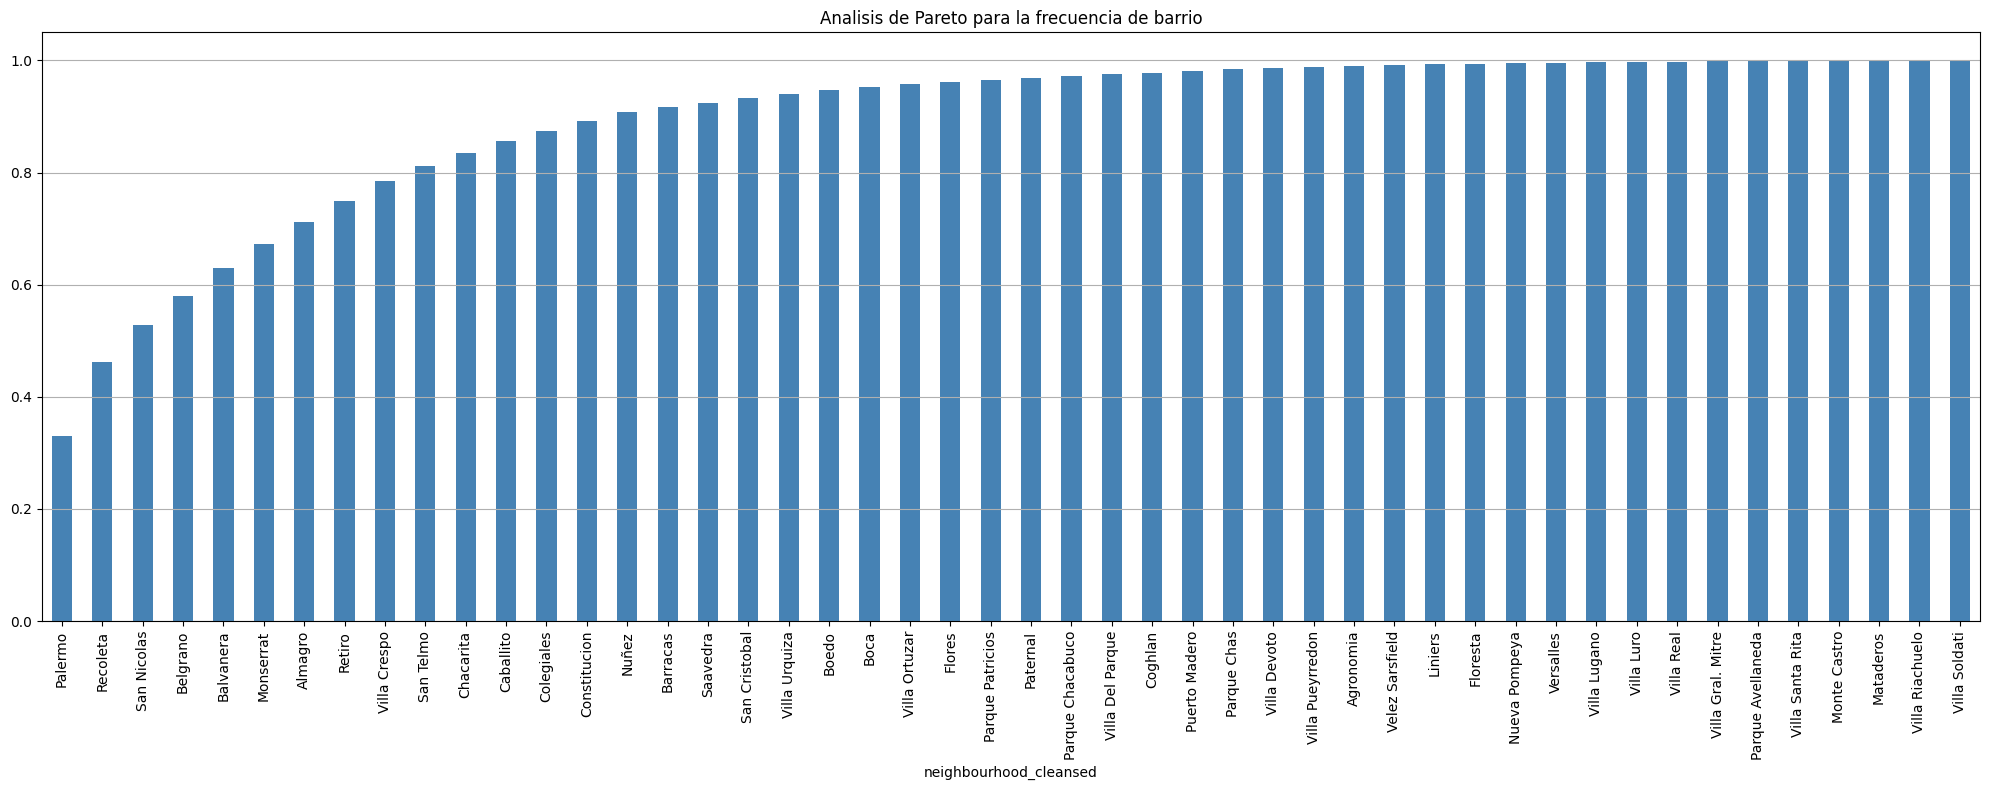

In [620]:
#Analisis de Pareto
neighbourhood_frec_cumsum = listings_df.loc[listings_df["On_Price_Q1-Q3_Range"]]["neighbourhood_cleansed"].value_counts(normalize=True).cumsum()
plt.figure(figsize=(20, 8))
neighbourhood_frec_cumsum.plot(kind="bar", color="steelblue")
plt.title("Analisis de Pareto para la frecuencia de barrio")
plt.grid(axis="y")
plt.show()

In [621]:
#Barrios representativos
most_representative_neighbourhoods = neighbourhood_frec_cumsum.loc[neighbourhood_frec_cumsum < 0.8].index.tolist()
print(len(most_representative_neighbourhoods))
print(most_representative_neighbourhoods)

9
['Palermo', 'Recoleta', 'San Nicolas', 'Belgrano', 'Balvanera', 'Monserrat', 'Almagro', 'Retiro', 'Villa Crespo']


Como se evidencia anteriormente, la variable neighbourhood_cleansed determina la ubicación por barrio en la cual esta ubicada el inmueble. La base de datos contempla los48 barrios de la ciudad de Buenos Aires Argentina. Como podemos ver en el analisis de Pareto, a pesar de que se tienen 48 barrios en total, el 80% de los predios se encuentra ubicado solo en 9, siendo estos>

'Palermo', 'Recoleta', 'San Nicolas', 'Belgrano', 'Retiro', 'Monserrat', 'Almagro', 'Villa Crespo', 'Balvanera'

Siendo el mas popular de todos Palermo, con mas del 35% de la totalidad de los inmuebles. Apriori se podria pensar que estos predios estan ubicados cerca de las zonas mas turisticas, o cerca a grandes centros empresariales. 



## 4.Estrategia

La estrategia propuesta para la identificación de las mejores oportuinidades de inversión en la cidudad de Buenos Aires, parte de dos importantes fuentes de información.

La primera es el mismo AirBNB que contempla toda la información aqui analizada, asi como una calculadora de rendimiento esperado para diferentes tipos de predios en cada ciudad del mundo. Este se calcula a traves del valor de cada noche en el inmueble, multiplicado por 365 dias años. Posteriormente este valor se multiplica for el inverso de la disponibilidad, lo cual nos da un estimado, de la cantidad de noches que el predio podria mantenerse ocupado, acorde a la información del ultimo año. Basado en esta información es posible generar un estimativo del ingreso anual que generaria un inmueble. 

Por otro lado, utilizando información de fuentes de datos de inmobiliarias ampliamente conocidas en Argentina, se estima el valor del m2 en Buenos Aires, asi como una distribución del area requerida por cantidad de habitaciones en los inmuebles. Con esta información, junto con la información generada anteriormente, es posible generar estimativos de inversion, como puede ser VAN, TIR, ROI, etc para estimar las mejores oportunidades de adquisición con el mayor rendimiento o o el menor tiempo de retorno de la inversión.

Junto con la información generada, tambien se encontraran posibles correlaciones entre el tipo de vivienda, las amenidades, la localización y las variables economicas recien generadas, lo que nos permitira dar el mayor posible rendimiento. Para este calculo encontraremos la correlación de las variables de reviews, para determinar cuales son los factores mas relevantes a la hora de determinar que un inmueble tiene mejor o menor calificación, dado que esto permitira al inversor estimar que debe tener en cuenta para asegurar la mayor ocupación. Por otro lado, se estimara la relación que existe entre el tamaño de un predio y su precio, asi como la relación que existe entre la ubicación y el precio, para asegurar la mejor inversión, en la medida de lo posible la mas baja. 

Finalmente, se empleara mediads de correlación para encontrar posibles tendencias o relaciones entre la disponibilidad de un predio, asi como su respectivo tamaño o ubicación, de modo que se obtenga la mejor combinación localización / ubicación para la respectiva inversión.

## 5.Desarrollo de la estrategia

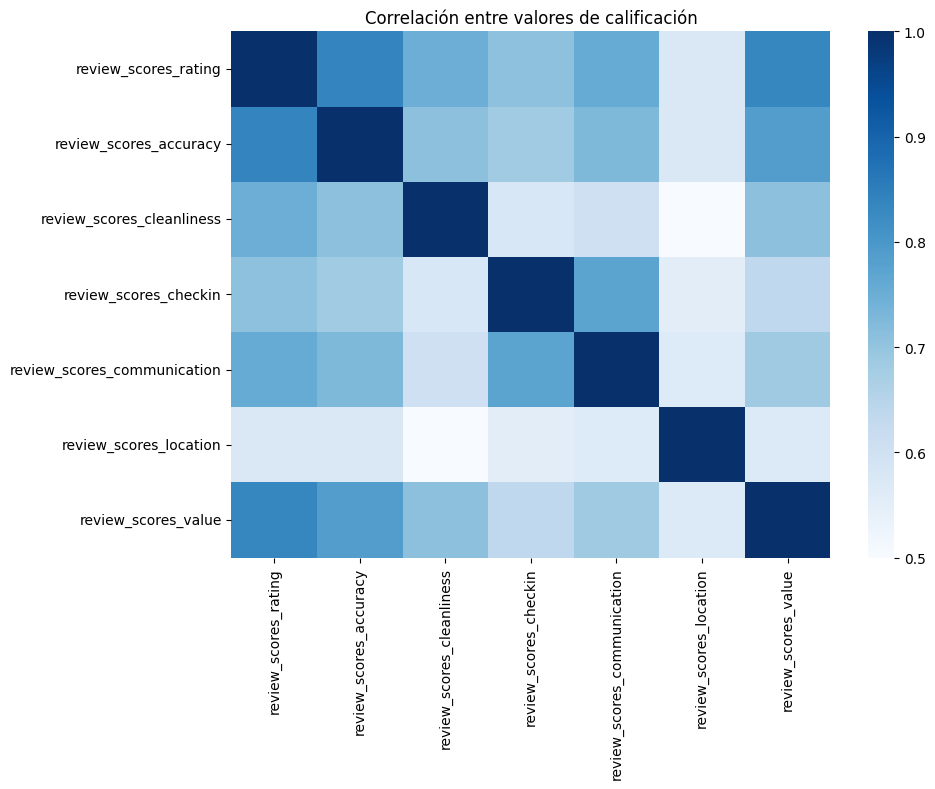

In [622]:
#Correlación de variables de review
plt.figure(figsize=(10, 8))
sns.heatmap(
    listings_df[["review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value"]].corr(),
    vmin=0.5, vmax=1,
    cmap="Blues"
)
plt.title("Correlación entre valores de calificación")
plt.show()

In [623]:
#muestra representativa
listings_sample_df =  listings_df.loc[listings_df["On_Price_Q1-Q3_Range"]].sample(frac=0.1)
listings_sample_df.shape

(530, 79)

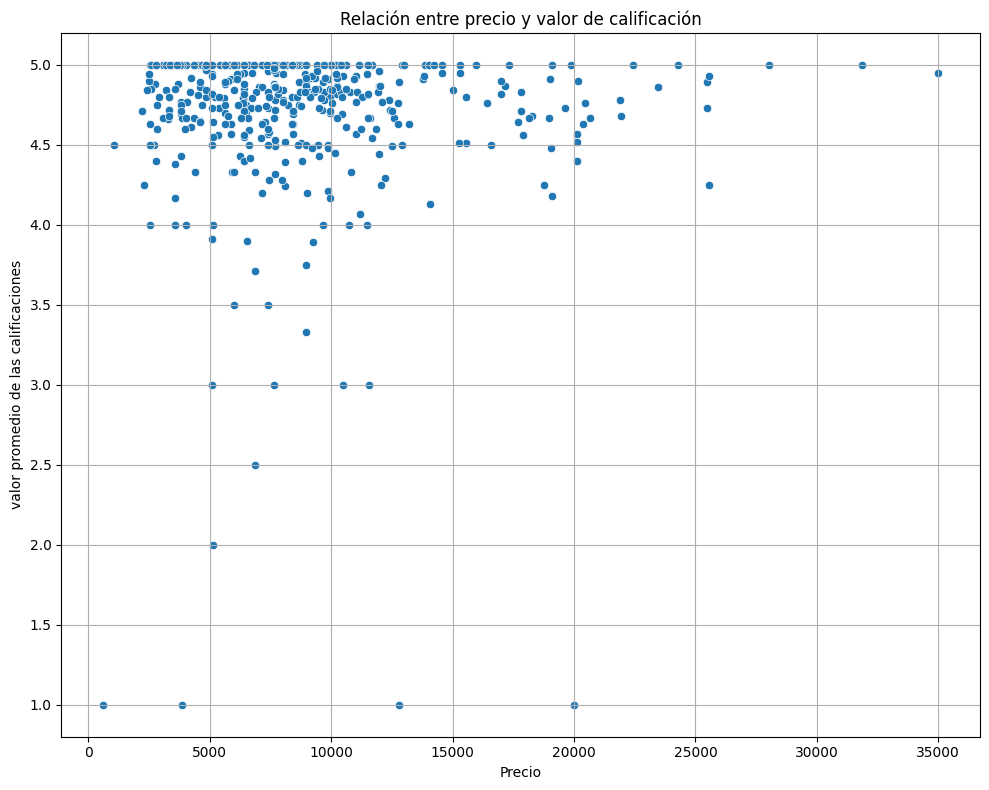

In [624]:
#
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=listings_sample_df["price_float"],
    y=listings_sample_df["review_scores_value"]
)
plt.title("Relación entre precio y valor de calificación")
plt.ylabel("valor promedio de las calificaciones")
plt.xlabel("Precio")
plt.grid()
plt.show()

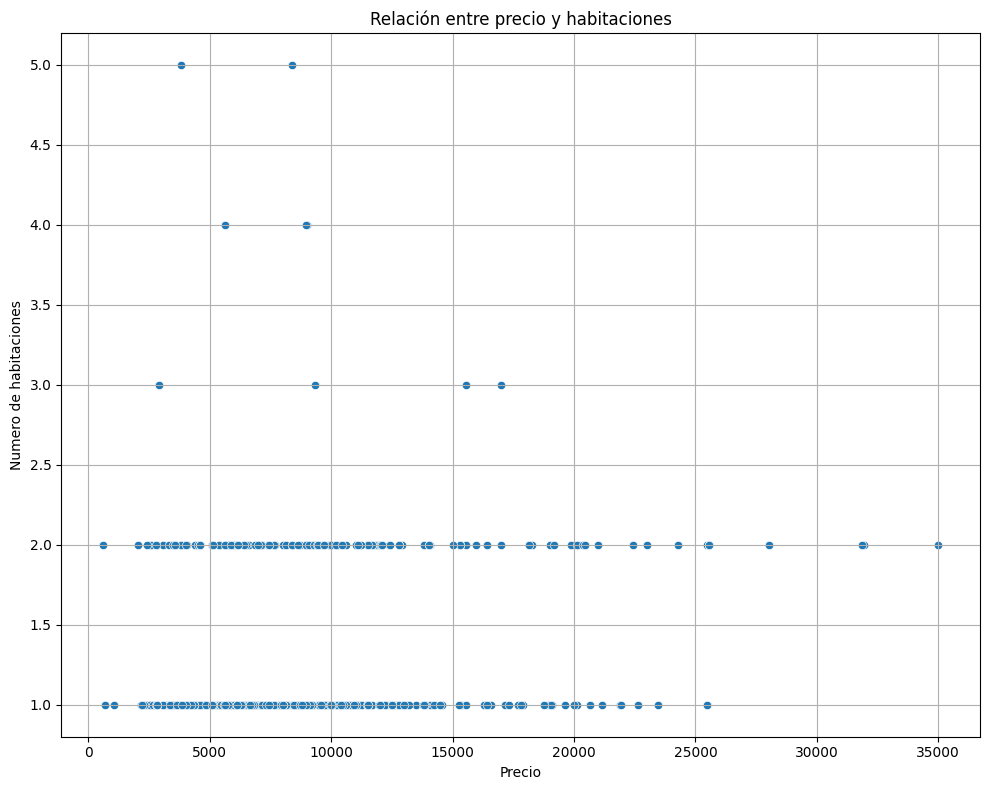

In [625]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=listings_sample_df["price_float"],
    y=listings_sample_df["bedrooms_modified"]
)
plt.title("Relación entre precio y habitaciones")
plt.ylabel("Numero de habitaciones")
plt.xlabel("Precio")
plt.grid()
plt.show()

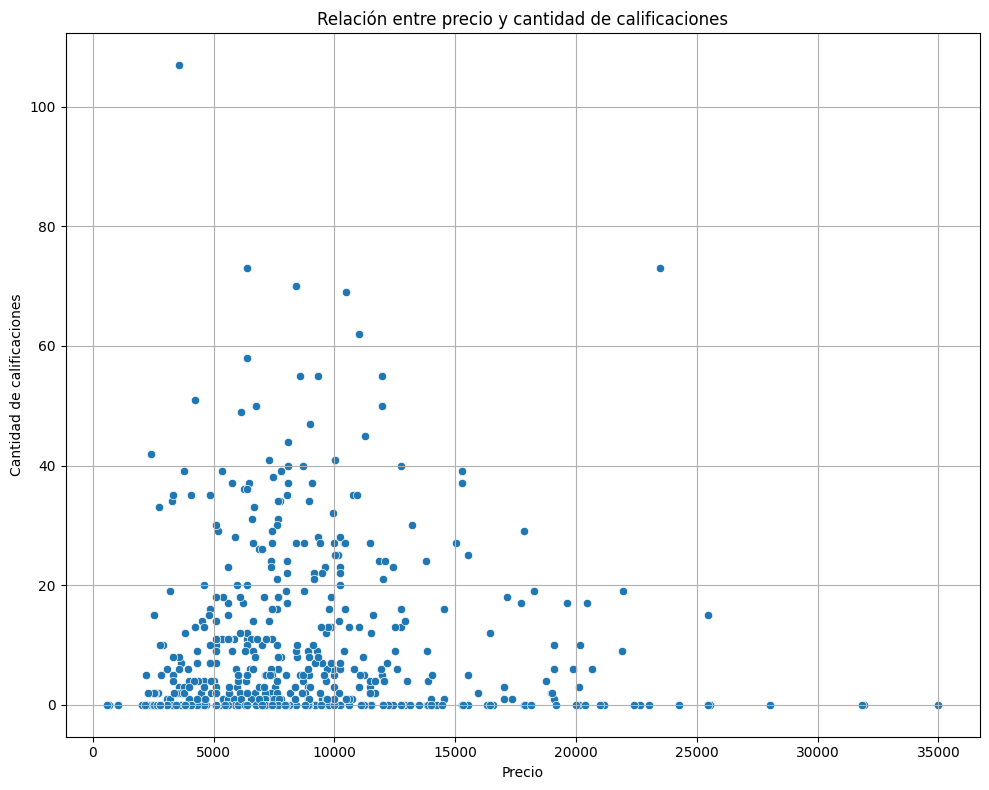

In [626]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=listings_sample_df["price_float"],
    y=listings_sample_df["number_of_reviews_ltm"]
)
plt.title("Relación entre precio y cantidad de calificaciones")
plt.ylabel("Cantidad de calificaciones")
plt.xlabel("Precio")
plt.grid()
plt.show()

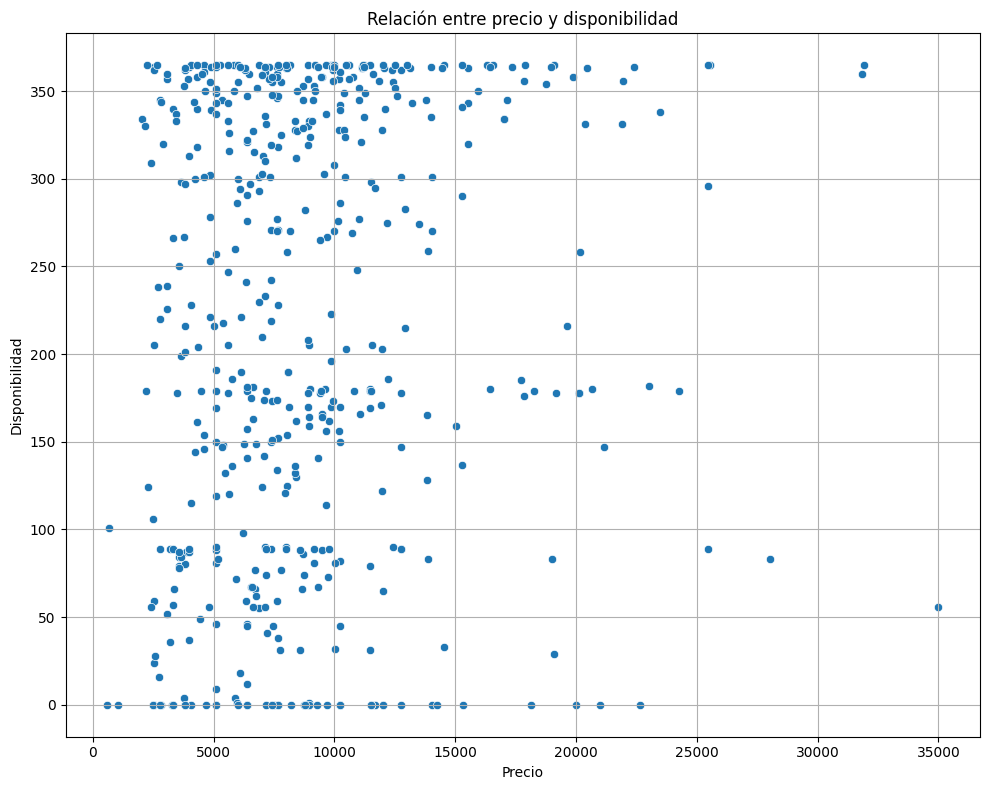

In [627]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=listings_sample_df["price_float"],
    y=listings_sample_df["availability_365"]
)
plt.ylabel("Disponibilidad")
plt.xlabel("Precio")
plt.title("Relación entre precio y disponibilidad")
plt.grid()
plt.show()

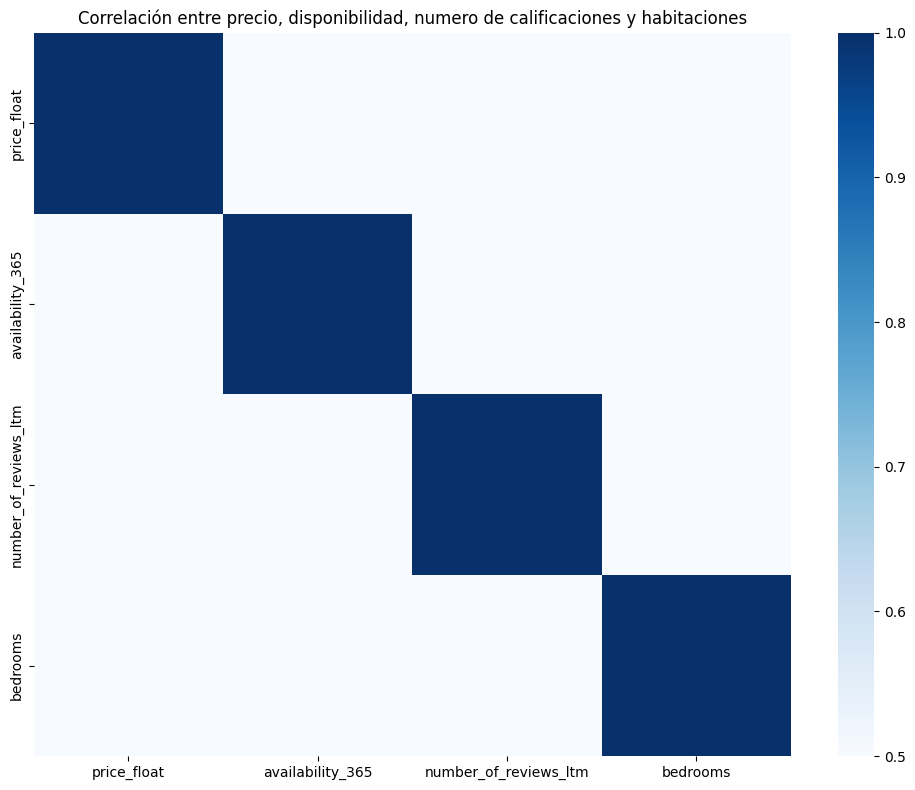

                       price_float  availability_365  number_of_reviews_ltm  \
price_float               1.000000         -0.009376              -0.019078   
availability_365         -0.009376          1.000000               0.026166   
number_of_reviews_ltm    -0.019078          0.026166               1.000000   
bedrooms                  0.038916         -0.014057              -0.024692   

                       bedrooms  
price_float            0.038916  
availability_365      -0.014057  
number_of_reviews_ltm -0.024692  
bedrooms               1.000000  


In [628]:
#Correlación de las variables anteriormente mostradas
plt.figure(figsize=(10, 8))
sns.heatmap(
    listings_df[["price_float", "availability_365", "number_of_reviews_ltm", "bedrooms"]].corr(),
    vmin=0.5, vmax=1,
    cmap="Blues"
)
plt.title("Correlación entre precio, disponibilidad, numero de calificaciones y habitaciones")
plt.show()

print(listings_df[["price_float", "availability_365", "number_of_reviews_ltm", "bedrooms"]].corr())

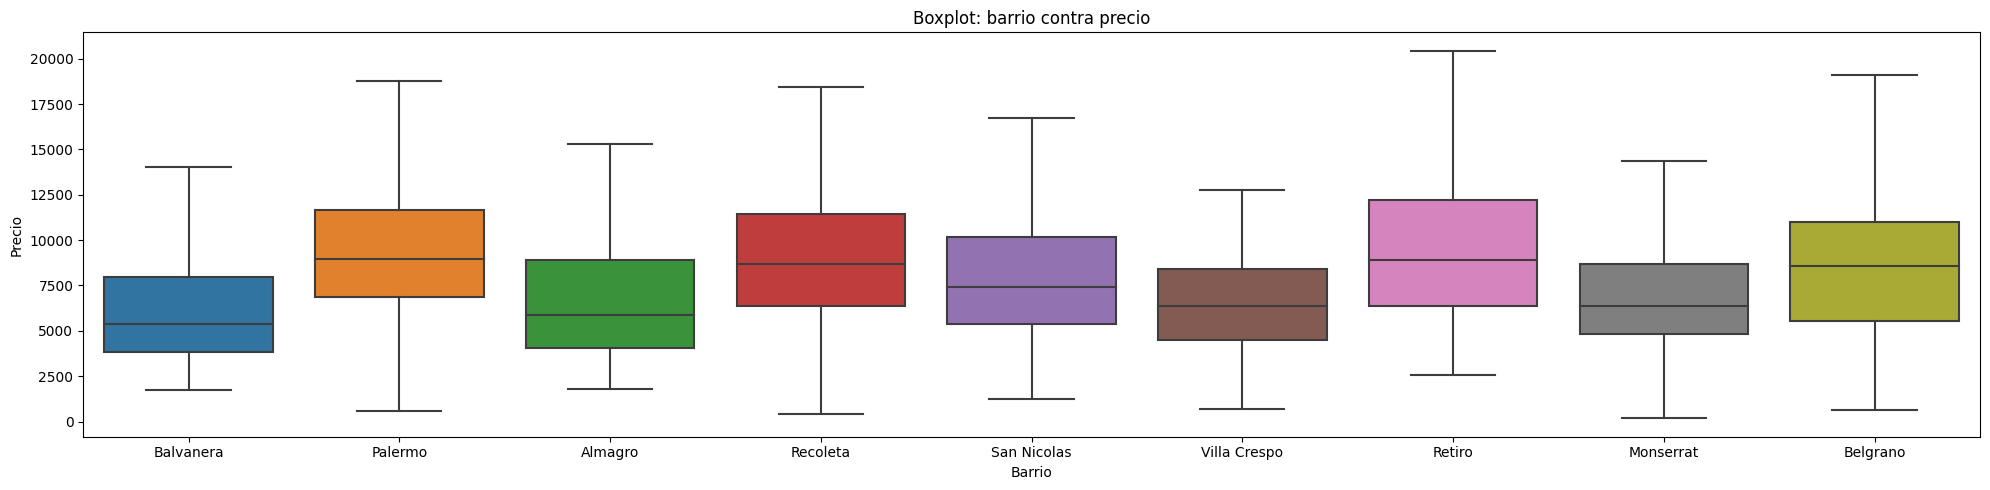

In [629]:
# Boxplot barrio contra precio
DataBoxPlot = listings_df.loc[(listings_df["On_Price_Q1-Q3_Range"])&(listings_df["neighbourhood_cleansed"].isin(most_representative_neighbourhoods))][["price_float","neighbourhood_cleansed","number_of_reviews_ltm","availability_365"]]
plt.figure(figsize=(20, 5))
sns.boxplot(DataBoxPlot, x="neighbourhood_cleansed", y="price_float", showfliers=False)
plt.title("Boxplot: barrio contra precio")
plt.ylabel("Precio")
plt.xlabel("Barrio")
plt.show()

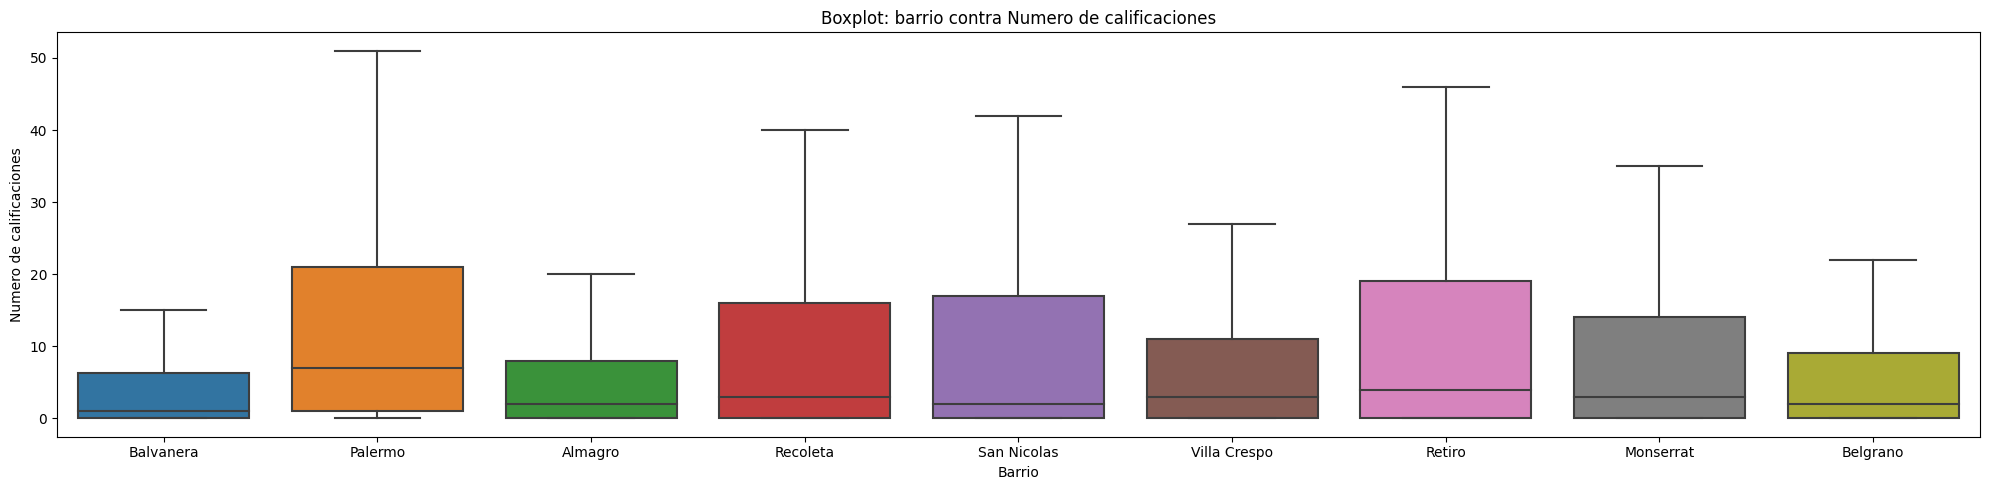

In [630]:
# Boxplot barrio contra numero de calificaciones
plt.figure(figsize=(20, 5))
sns.boxplot(DataBoxPlot, x="neighbourhood_cleansed", y="number_of_reviews_ltm", showfliers=False)
plt.title("Boxplot: barrio contra Numero de calificaciones")
plt.ylabel("Numero de calificaciones")
plt.xlabel("Barrio")
plt.show()

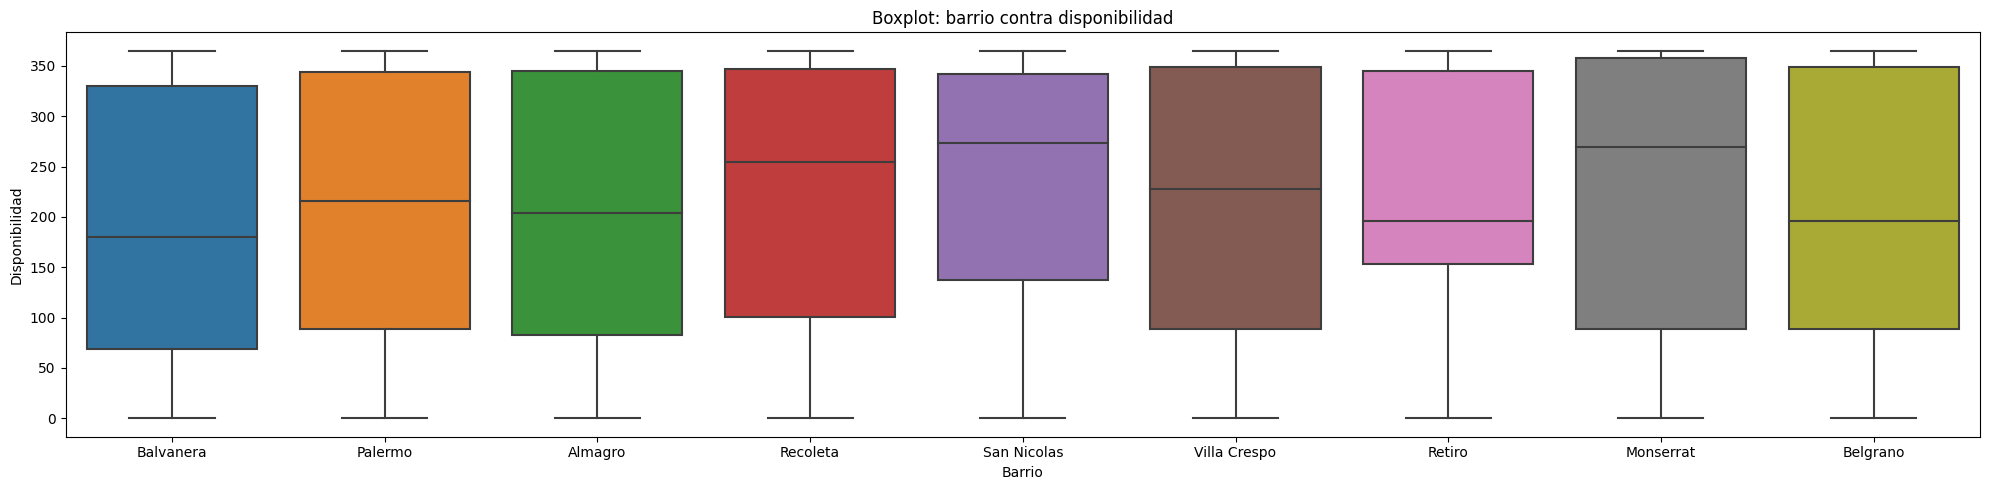

In [631]:
# Boxplot barrio contra disponibilidad
plt.figure(figsize=(20, 5))
sns.boxplot(DataBoxPlot, x="neighbourhood_cleansed", y="availability_365", showfliers=False)
plt.title("Boxplot: barrio contra disponibilidad")
plt.ylabel("Disponibilidad")
plt.xlabel("Barrio")
plt.show()

In [632]:
#Creación de bases para ANOVA

DF_Palermo = DataBoxPlot.loc[DataBoxPlot["neighbourhood_cleansed"]=="Palermo"]
DF_Recoleta = DataBoxPlot.loc[DataBoxPlot["neighbourhood_cleansed"]=="Recoleta"]
DF_SanNicolas = DataBoxPlot.loc[DataBoxPlot["neighbourhood_cleansed"]=="San Nicolas"]
DF_Belgrano = DataBoxPlot.loc[DataBoxPlot["neighbourhood_cleansed"]=="Belgrano"]
DF_Retiro = DataBoxPlot.loc[DataBoxPlot["neighbourhood_cleansed"]=="Retiro"]
DF_Monserrat = DataBoxPlot.loc[DataBoxPlot["neighbourhood_cleansed"]=="Monserrat"]
DF_Almagro = DataBoxPlot.loc[DataBoxPlot["neighbourhood_cleansed"]=="Almagro"]
DF_VillaCrespo = DataBoxPlot.loc[DataBoxPlot["neighbourhood_cleansed"]=="Villa Crespo"]
DF_Balvanera = DataBoxPlot.loc[DataBoxPlot["neighbourhood_cleansed"]=="Balvanera"]

print(DF_SanNicolas)



       price_float neighbourhood_cleansed  number_of_reviews_ltm  \
175         8943.0            San Nicolas                     12   
500         6388.0            San Nicolas                      0   
554         6679.0            San Nicolas                     13   
634         8662.0            San Nicolas                      0   
689        10146.0            San Nicolas                     28   
...            ...                    ...                    ...   
25734       7424.0            San Nicolas                      0   
25956       8432.0            San Nicolas                      0   
26134       6114.0            San Nicolas                      0   
26198       9900.0            San Nicolas                      0   
26201       9900.0            San Nicolas                      0   

       availability_365  
175                 335  
500                 332  
554                 163  
634                 365  
689                 171  
...                 ...  
2

In [633]:
#Estudio ANOVA Barrio-Precio
f_oneway(DF_Palermo["price_float"],DF_Recoleta["price_float"],DF_SanNicolas["price_float"],DF_Belgrano["price_float"],DF_Retiro["price_float"],DF_Monserrat["price_float"],DF_Almagro["price_float"],DF_VillaCrespo["price_float"],DF_Balvanera["price_float"])

F_onewayResult(statistic=35.16900509957902, pvalue=2.9985830777990897e-54)

In [634]:
#Estudio ANOVA Barrio-Numero de calificaciones
f_oneway(DF_Palermo["number_of_reviews_ltm"],DF_Recoleta["number_of_reviews_ltm"],DF_SanNicolas["number_of_reviews_ltm"],DF_Belgrano["number_of_reviews_ltm"],DF_Retiro["number_of_reviews_ltm"],DF_Monserrat["number_of_reviews_ltm"],DF_Almagro["number_of_reviews_ltm"],DF_VillaCrespo["number_of_reviews_ltm"],DF_Balvanera["number_of_reviews_ltm"])

F_onewayResult(statistic=17.006264883148923, pvalue=4.255710354128434e-25)

In [635]:
#Estudio ANOVA Barrio-Disponibilidad
f_oneway(DF_Palermo["availability_365"],DF_Recoleta["availability_365"],DF_SanNicolas["availability_365"],DF_Belgrano["availability_365"],DF_Retiro["availability_365"],DF_Monserrat["availability_365"],DF_Almagro["availability_365"],DF_VillaCrespo["availability_365"],DF_Balvanera["availability_365"])

F_onewayResult(statistic=3.1646675644579383, pvalue=0.0014051072254640882)

In [636]:
#Generación valores finales y economicos
FinalResume = DataBoxPlot.groupby(["neighbourhood_cleansed"])[["price_float","availability_365","number_of_reviews_ltm"]].mean()
FinalResume["occupance"]=(365-FinalResume["availability_365"])
FinalResume["Proyected_Income"]=FinalResume["occupance"]*FinalResume["price_float"]
TRM = 352
Expectedm2 = 60
FinalResume["expected_house/apt_price"] = 1685
FinalResume.index
FinalResume.loc[FinalResume.index=="Almagro","expected_house/apt_price"] = 1685
FinalResume.loc[FinalResume.index=="Balvanera","expected_house/apt_price"] = 1421
FinalResume.loc[FinalResume.index=="Villa Crespo","expected_house/apt_price"] = 1709
FinalResume.loc[FinalResume.index=="Monserrat","expected_house/apt_price"] = 1448
FinalResume.loc[FinalResume.index=="San Nicolas	","expected_house/apt_price"] = 1431
FinalResume.loc[FinalResume.index=="Retiro","expected_house/apt_price"] = 1682
FinalResume.loc[FinalResume.index=="Belgrano","expected_house/apt_price"] = 2138
FinalResume.loc[FinalResume.index=="Recoleta","expected_house/apt_price"] = 1978
FinalResume.loc[FinalResume.index=="Palermo","expected_house/apt_price"] = 2079
FinalResume["expected_house/apt_price"]=FinalResume["expected_house/apt_price"]*TRM*Expectedm2
FinalResume["expected_Return_of_Investment"]=FinalResume["expected_house/apt_price"]/FinalResume["Proyected_Income"]


In [637]:
FinalResume.sort_values(by="expected_Return_of_Investment")

,price_float,availability_365,number_of_reviews_ltm,occupance,Proyected_Income,expected_house/apt_price,expected_Return_of_Investment
neighbourhood_cleansed,,,,,,,
Retiro,10687.964286,223.020408,14.229592,141.979592,1.517473e+06,35523840,23.409869
Balvanera,6357.660448,188.022388,5.779851,176.977612,1.125164e+06,30011520,26.673029
Palermo,9979.233982,214.181922,14.102975,150.818078,1.505049e+06,43908480,29.174122
San Nicolas,8568.386819,228.034384,11.323782,136.965616,1.173574e+06,35587200,30.323770
Recoleta,9736.119658,224.247863,9.910256,140.752137,1.370380e+06,41775360,30.484516
Monserrat,7149.531532,227.752252,9.761261,137.247748,9.812571e+05,30581760,31.165899
Almagro,6850.298077,201.552885,5.264423,163.447115,1.119661e+06,35587200,31.783893
Belgrano,8918.891697,207.617329,7.552347,157.382671,1.403679e+06,45154560,32.168722
Villa Crespo,7039.497409,215.523316,7.813472,149.476684,1.052241e+06,36094080,34.302113


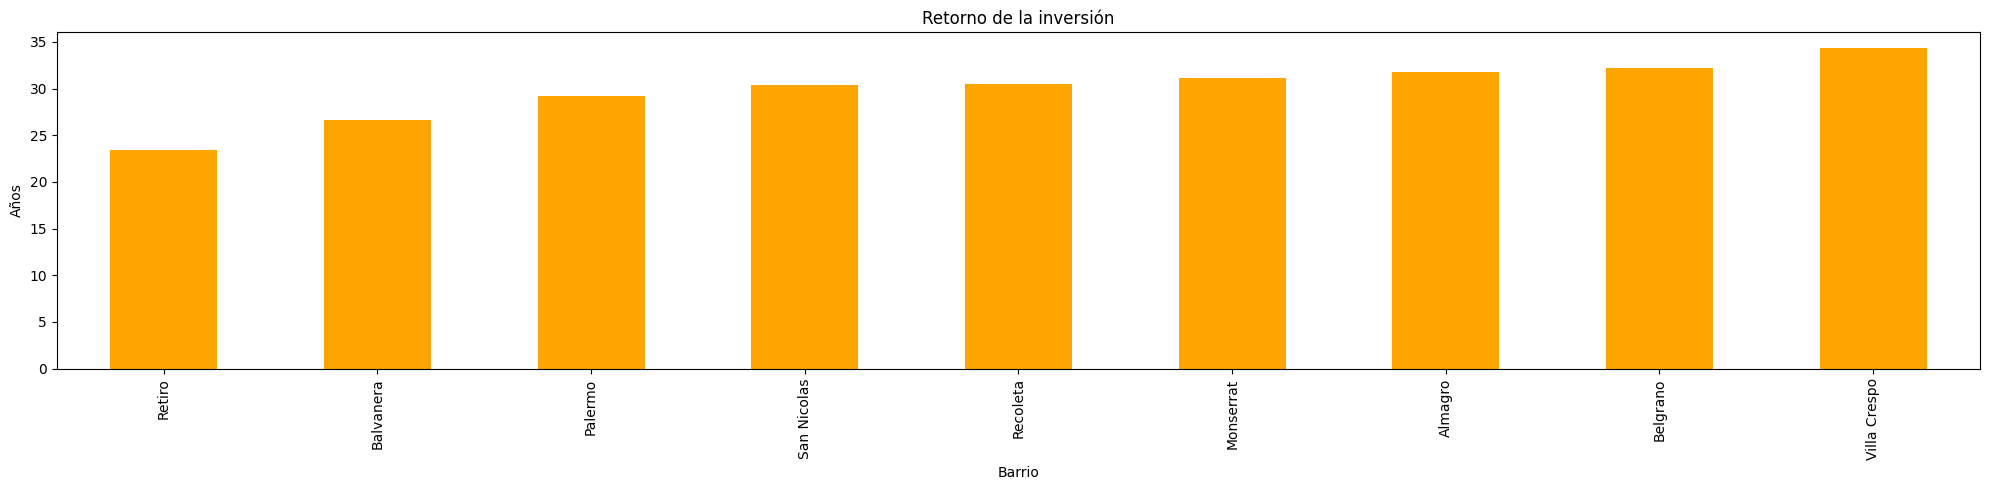

In [638]:
#Grafica retorno de inversión
plt.figure(figsize=(20, 5))
FinalResume.sort_values(by="expected_Return_of_Investment")["expected_Return_of_Investment"].plot(kind="bar", color="orange")
plt.ylabel("Años")
plt.xlabel("Barrio")
plt.title("Retorno de la inversión")
plt.show()


## 6.Resultados estrategia

Al finalizar el analisis entre las variables escogidas se evidencias algunos comportamientos importantes:

El primero: la cantidad de calificaciones, el tamaño del predio (representado por el numero de habitaciones), la disponibilidad y el precio no estan realmente correlacionadas entre ellas. Como se evidencia en el mapa de calor de correlación, estas variables no tienen ninguna corelación, ni positiva ni negativa, de modo que ninguna influye en el comportamiento de la otra.

A nivel visual se evidencia en las graficas de puntos que estas presentan una dsitribución uniforme en todos los casos, mostrandose mas prominentes hacia las areas de menor precio, dado que la media del precio de los inmuebles se encuentra en esta zona.

Segundo: Existe una correlación significativa entre el valor de la puntuación y lo claro que es la descripción del predio. De la misma manera se evidencia una corelación importante entre el valor de las calificaciones y la limpieza de los predios

Tercero: Despues de evidenciar las graficas de caja de las variables de precio, numero de calificaciones y disponibilidad contra el barrio, se evidencia algunas diferencias en las medias para cada barrio, sin embargo, no es evidente la diferencia. Considerando esto se lleva a cabo un analis de varianza ANOVA para determinar si las medias de cada barrio en estos aspectos son significativamente diferentes, y se evidencia que si. Especialmente para el precio, pero en los tres aspectos, se confirma que el valor de p-value es menor a 5% y por ende se rechaza la hipotesis nula (todas las medias son iguales), por ende se puede concluir que existen diferencias significativas entre el comportamientos de los predios con respecto al barrio.

Considerando lo anterior, se procede a realizar los calculos financieros aplicables a los barrios seleccionados, es decir, los 9 barrios que corresponden al 80% de los predios de la ciudad. Para este se lleva a cabo el calculo del ingreso de un año (proyectado) y el valor estimado del predio. Para este ultimo se selecciona el valor de metro cuadrado para cada barrio acorde a la ultima información de inmobiliarias, y se multiplica por un valor de 60m2, considerado este como un apartamento modelo para dos habitaciones, dado que no se encontro alguna variedad significante entre estas variables y el numero de habitaciones. Posteriormente, se tranforma el valor en pesos argentinos, usando la tasa de cambio del dia (352 pesos por dolar, a 3 de septiembre de 2023)

A patit de estos valores se calcula el tiempo de retorno de la inversión, considerando el valor del apartamento o casa como valor inicial o de inversion, y los flujos de caja como el ingreso anual proyectado. De este analsis se confirma que los 5 mejores barrios para invertir son Retiro, Monserrat, Balvanera, San Nicolas y Palermo.

## 7.INSIGHTS AL CLIENTE

Posterior a la revisión multivariada y univariada de las variables que componen esta base de datos, se evidencia que para el caso especifico de Buenos Aires, Argentina las variables de disponibilidad del predio, el numero de calificaciones o el tamaño del predio, no se encuentran corelacionadas con el precio. De modo que de invertir en la ciudad se recomienda que sea por un apartamento o casa de al menos dos habitaciones, dado que estas son el comun denominador en la ciudad. 

Por otro lado se recomienda una descripción muy detallada de las amenidades del inmueble, dado que esto esta relacionado con el valor de las puntuaciones que dan los usuarios, lo cual permite que estos sean arrendados mas seguido. Por otro lado, otro aspecto crucial en las reivisiones es la limpieza de los inmuebles, asi que es muy recomendable mantener en perfecto estado los inmuebles

En otro punto, se encontro que el barrio, efectivamente esta relacionado con la distribución de precios, la disponibilidad de los predios y el numero de calificaciones de los mismos. Si se considera el numero de calificaciones del ultimo año, como una medida de la demanda de estos predios, y la disponibilidad como una medida de la oferta, se evidencia que la mejro relación, esta en los 9 barrios mas significantes que corresponde a 'Palermo', 'Recoleta', 'San Nicolas', 'Belgrano', 'Retiro', 'Monserrat', 'Almagro', 'Villa Crespo' y 'Balvanera'. Los cuales corresponde o estan relacionados con puntos turisiticos o comerciales de Buenos Aires.

Finalmene, considerando el valor proyectado para inversión (considerando el valor del metro cuadrado por barrio) y el proyectado de ingresos que generara el predio (como una combinación de la disponibilidad por el precio por noche) se evidencia que los barrios Retiro, Monserrat y Balvanera tendran el menor retorno de inversion en años, junto con unas de las demandas mas grandes. 

Se muestran los datos a continuación:

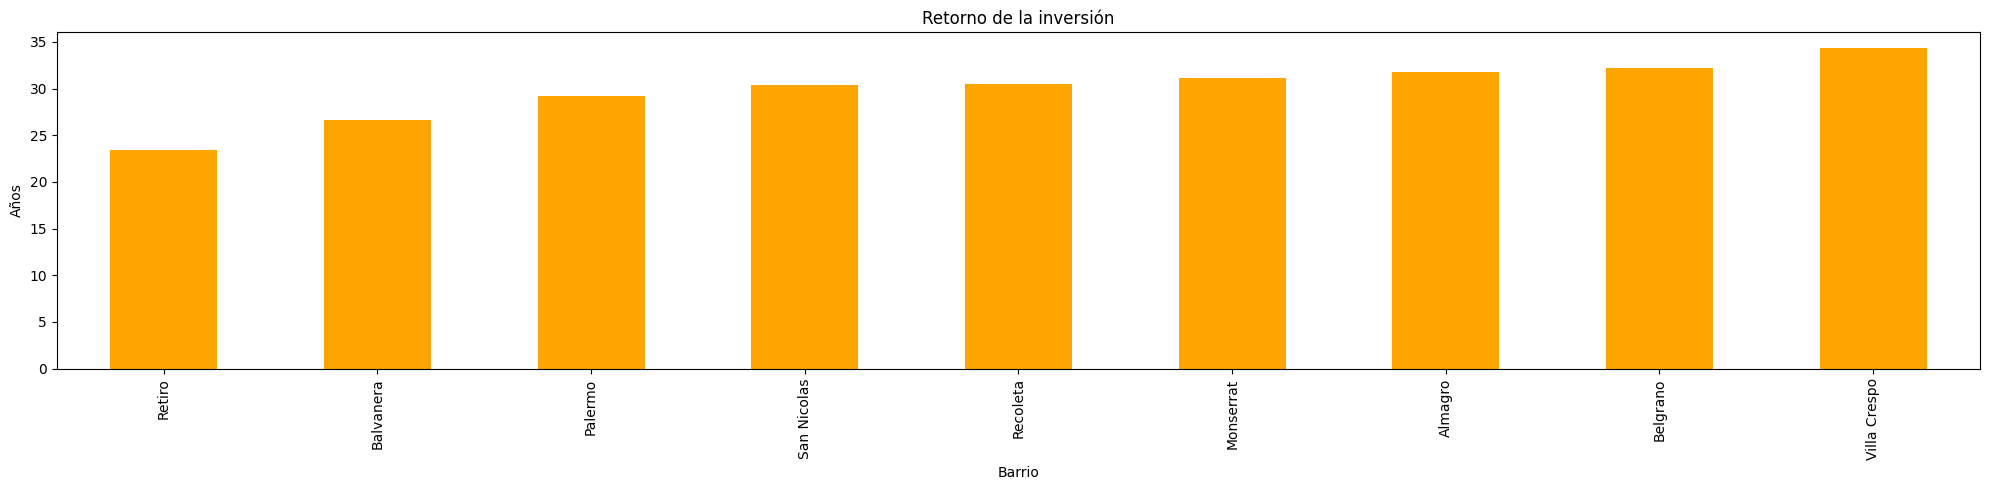

In [639]:
plt.figure(figsize=(20, 5))
FinalResume.sort_values(by="expected_Return_of_Investment")["expected_Return_of_Investment"].plot(kind="bar", color="orange")
plt.title("Retorno de la inversión")
plt.ylabel("Años")
plt.xlabel("Barrio")
plt.show()

In [640]:
FinalTabla = FinalResume[["number_of_reviews_ltm","availability_365","price_float","Proyected_Income","expected_Return_of_Investment"]].sort_values(by="expected_Return_of_Investment")
FinalTabla.rename(columns = {"number_of_reviews_ltm":'Numero de calificaciones',
                             "availability_365":'Disponibilidad',
                             "Proyected_Income":"Ingreso anual proyectado",
                             "expected_Return_of_Investment":"Retorno de la inversión esperado",
                             "price_float":"Precio por noche",
                             "neighbourhood_cleansed":"Barrio"}, inplace = True)
FinalTabla

,Numero de calificaciones,Disponibilidad,Precio por noche,Ingreso anual proyectado,Retorno de la inversión esperado
neighbourhood_cleansed,,,,,
Retiro,14.229592,223.020408,10687.964286,1.517473e+06,23.409869
Balvanera,5.779851,188.022388,6357.660448,1.125164e+06,26.673029
Palermo,14.102975,214.181922,9979.233982,1.505049e+06,29.174122
San Nicolas,11.323782,228.034384,8568.386819,1.173574e+06,30.323770
Recoleta,9.910256,224.247863,9736.119658,1.370380e+06,30.484516
Monserrat,9.761261,227.752252,7149.531532,9.812571e+05,31.165899
Almagro,5.264423,201.552885,6850.298077,1.119661e+06,31.783893
Belgrano,7.552347,207.617329,8918.891697,1.403679e+06,32.168722
Villa Crespo,7.813472,215.523316,7039.497409,1.052241e+06,34.302113


# Bibliografia:

Calculadora de ingresos AirBNB: https://analytics.alltherooms.com/investor/calculator

Inmobiliaria CABA:              https://mudafy.com.ar/d/valor-metro-cuadrado-en-caba-por-barrio

Inmobiliaria Maure:             https://maureinmobiliaria.com/metro-cuadrado/